In [1]:
import json
from pathlib import Path
import pickle

from rich.progress import track

import pandas as pd

In [2]:
EXPERIMENT_NAME = "base-experiment"
ANALYSIS_BASE = "./analysis/paper-data/"
INCLUDE_EWMA = False
INCLUDE_GRADIENTS = False

CROSS_VALIDATIONS_PATH = f"./cross-validations-{EXPERIMENT_NAME}"


In [3]:
def filter_dataframe_for_current_experiment(data_flattened):
    df = data_flattened.loc[(slice(None), slice(None), INCLUDE_GRADIENTS, INCLUDE_EWMA), :]
    df.index = df.index.droplevel([2, 3])
    df = df.sort_values(by=['percentage', 'model'])

    def float_or_list_to_tuple(x):
        if isinstance(x, list):
            return tuple(x)
        return x

    df["hidden_layer_sizes"] = df['hidden_layer_sizes'].apply(float_or_list_to_tuple)
    return df

In [4]:

def parse_files(cross_validations_path, seed):
    """
    Parse files and use pd.json_normalize to flatten the json.
    """
    files = Path(ANALYSIS_BASE).joinpath(f"{cross_validations_path}-{seed}").glob("**/*.json")
    results = pd.DataFrame()
    files = list(files)

    for file in track(
        files,
        description="Loading hyperparameters and "
        "performance data from file to DataFrame",
    ):
        with open(file) as f:
            data = json.load(f)
            original_target = data["original_target"]
            original_dict = json.loads(Path(original_target).read_text())

            f1_scores = pd.json_normalize(data, "f1_scores")
            normalized_data = pd.json_normalize(original_dict)
            normalized_data = pd.concat(
                [normalized_data] * len(f1_scores), ignore_index=True
            )
            normalized_data["metrics.f1_score"] = f1_scores
            normalized_data["paths.model_path"] = data["model_path"]
            results = pd.concat([results, normalized_data])

    results = results.set_index(
        ["percentage", "model", "use_gradient", "use_ewma"]
    )
    results.columns = pd.MultiIndex.from_arrays(
        zip(*results.columns.str.split(".", expand=True))
    )
    results = results.sort_index(axis=1)
    results = results.drop(columns=['k_fold', 'preprocessing'])
    results = results.droplevel(0, axis=1)

    results = filter_dataframe_for_current_experiment(results)

    return results

In [5]:
def pick_best_hyperparameters_from_k_folds(k_folds_data):

    PERCENTAGES = [1, 5, 10, 15, 20, 25, 30, 35, 40 ]
    MODELS = ['RF', 'DUM', 'ET', 'AdaBoost']
    FILTER_MODELS = True

    # This is a bit hacky, but I add model_path here because its only always the same
    # so it doesn't have effect on the groupby.
    # Would be better to `df.merge` though.
    group = k_folds_data.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha', 'model_path'], dropna=False)
    summary = group['f1_score'].agg(['mean', 'std'])

    idx = summary.groupby(['percentage', 'model']).idxmax()

    best_hyperparams = summary.loc[idx['mean'], :]

    best_models_per_percentage_and_type = best_hyperparams[best_hyperparams.index.get_level_values('percentage').isin(PERCENTAGES)]
    if FILTER_MODELS:
        best_models_per_percentage_and_type =  best_models_per_percentage_and_type[best_models_per_percentage_and_type.index.get_level_values('model').isin(MODELS)]
    return best_models_per_percentage_and_type



In [6]:
def load_classifiers_from_best_models(best_models_per_percentage_and_type):
    classifiers = {}
    for _, row in best_models_per_percentage_and_type.reset_index().iterrows():
        
        with open(row['model_path'], 'rb') as f:
            instantiated_model = pickle.load(f)
        classifiers[(row['percentage'], row['model'])] = instantiated_model
    return classifiers

In [ ]:
data_for_all_seeds = []
for i in range(1,11):

    current_seed = {
        'seed': i
    }

    data = parse_files(Path(CROSS_VALIDATIONS_PATH), seed=i)
    current_seed['k_fold'] = data
    
    current_seed['best_models'] = pick_best_hyperparameters_from_k_folds(data)
    current_seed['classifiers'] = load_classifiers_from_best_models(current_seed['best_models'])

    TEST_DATASET_PATH = Path(f'./analysis/paper-data/{EXPERIMENT_NAME}-{i}.pkl_test.pkl')
    with open(TEST_DATASET_PATH, 'rb') as f:
        TEST_DATASET = pickle.load(f)
        TEST_DATASET = TEST_DATASET
        
    TRAIN_DATASET_PATH = Path(f'./analysis/paper-data/{EXPERIMENT_NAME}-{i}.pkl_train.pkl')
    with open(TRAIN_DATASET_PATH, 'rb') as f:
        TRAIN_DATASET = pickle.load(f)
        TRAIN_DATASET = TRAIN_DATASET

    current_seed['train_data'] = TRAIN_DATASET
    current_seed['test_data'] = TEST_DATASET
    
    data_for_all_seeds += [current_seed]

# Utility

In [8]:
from sklearn.preprocessing import MaxAbsScaler
def preprocess(dataframe, scaler=None):
    result, _ = dataframe.drop(columns=['mzn', 'dzn'], axis=1), dataframe['mzn']

    # Drop any columns that contain the text 'ewma' or 'gradient'
    result = result.drop(columns=result.columns[result.columns.str.contains('ewma|gradient')], axis=1)
    result = result.drop(result.columns[result.nunique() == 1], axis=1)

    
    scaler = MaxAbsScaler().fit(result)    
    # result = pd.DataFrame(scaler.transform(result), columns=result.columns, index=result.index)

    return result




In [9]:
def combine_seed_data_into_single_dataframe_opinionated(total_data):
    dfs = []
    for seed in total_data:
        best_models_copy = seed['best_models'].copy()
        best_models_copy['seed'] = seed['seed']
        dfs.append(best_models_copy)
    return pd.concat(dfs)

In [ ]:
data_for_all_seeds

# Now here we can split off: our base experiment.

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

In [12]:
# temp = data_for_all_seeds[1]['k_fold']
# group = temp.groupby(['percentage', 'model', 'C', 'hidden_layer_sizes', 'kernel', 'learning_rate', 'max_depth', 'n_estimators', 'alpha', 'model_path'], dropna=False)
# summary = group['f1_score'].agg(['mean', 'std'])

In [50]:
from collections import defaultdict
def fit_and_test_model(test_data, train_data, instantiated_model):
    test_x, test_y = test_data.drop(['solved_within_time_limit'], axis=1), test_data['solved_within_time_limit']
    train_x, train_y = train_data.drop(['solved_within_time_limit'], axis=1), train_data['solved_within_time_limit']
    
    test_x = preprocess(test_x)
    train_x = preprocess(train_x)
    
    train_x = train_x[['frac_long_clauses', 'frac_long_clauses', 'frac_prop_vars', 'boolVars', 'long', 'tern', 'bin']]
    test_x = test_x[['frac_long_clauses', 'frac_long_clauses', 'frac_prop_vars', 'boolVars', 'long', 'tern', 'bin']]
    instantiated_model.fit(train_x, train_y)
    
      # Predict on the test set using all features
    y_pred = instantiated_model.predict(test_x)
    
    # Compute the F1 score
    score = f1_score(test_y, y_pred, average='binary')
    return score



def run_best_models_on_test_set(all_data):
    results = defaultdict(list)
    for seed in all_data:
        test_data = seed['test_data']
        train_data = seed['train_data']
        for k, instantiated_model in seed['classifiers'].items():
            percentage, model = k
            f1_score = fit_and_test_model(test_data=test_data[percentage], train_data=train_data[percentage], instantiated_model=instantiated_model)
            results[k].append(f1_score)
    return pd.DataFrame.from_records([{'percentage': k[0], 'model': k[1], 'mean': np.mean(v), 'std': np.std(v)} for k, v in dict(results).items()])
            

In [51]:
f1s = run_best_models_on_test_set(data_for_all_seeds)


/home/alexander/ssd/Research/done-soon-paper/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexander/ssd/Research/done-soon-paper/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexander/ssd/Research/done-soon-paper/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/alexander/ssd/Research/done-soon-paper/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R alg

In [48]:
f1s

,percentage,model,mean,std
0,1,AdaBoost,0.878183,0.027374
1,1,DUM,0.537684,0.038881
2,1,ET,0.901049,0.025359
3,1,RF,0.893247,0.019260
4,5,AdaBoost,0.826604,0.047014
5,5,DUM,0.377163,0.076301
6,5,ET,0.864981,0.047376
7,5,RF,0.855682,0.048150
8,10,AdaBoost,0.739772,0.071647
9,10,DUM,0.344904,0.058555


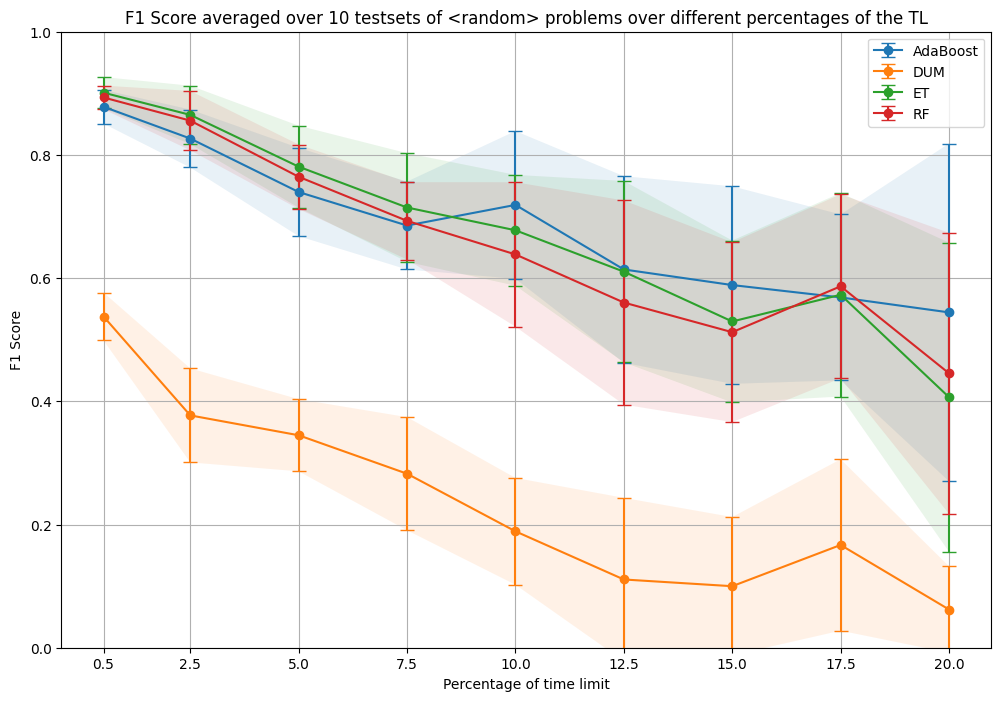

In [49]:
def plot_results(results):
    plt.figure(figsize=(12, 8))

    
    
    for model in results['model'].unique():
        results_for_model = results[results['model'] == model]
        percentages = results_for_model['percentage'] / 2
        f1_scores_mean = results_for_model['mean']
        f1_scores_std = results_for_model['std']
        plt.errorbar(percentages, f1_scores_mean, yerr=f1_scores_std, fmt='o-', capsize=5, label=f'{model}')
        plt.fill_between(percentages, 
                        np.array(f1_scores_mean) - np.array(f1_scores_std), 
                        np.array(f1_scores_mean) + np.array(f1_scores_std), 
                        alpha=0.1)

    plt.title('F1 Score averaged over 10 testsets of <random> problems over different percentages of the TL')
    plt.xlabel('Percentage of time limit')
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.ylim(0, 1)
    plt.xticks(percentages)
    plt.legend()
    plt.show()
plot_results(f1s)